In [2]:
from contextlib import nullcontext
import torch
from utils import load_model, get_tokenizer, print_gpu_utilization, time_gpu

# -----------------------------------------------------------------------------
init_from = ['resume', 'eval_llama', 'llama', 'gpt2-small', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'][2] # or 'resume' or 'gpt2-medium' or 'gpt2-large' or 'gpt2-xl'
out_dir = ""
start = "###User: Write a few words on Einstein.\n###Bot:" ## Can also specify a file, use as: "FILE:prompt.txt"
num_samples =  3  # number of samples to draw
max_new_tokens = 200 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster

# learning block
learning_block = False
influence = 0.5

## sampling
break_at_eos = True
eos_token_id = 2
# -----------------------------------------------------------------------------

model_type = 'llama' if 'llama' in init_from else 'gpt2'
sampling = "format" # "discrete" or "continuous" or "format"


torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

torch.set_default_dtype(ptdtype)

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# model
model, model_args = load_model(model_type, out_dir, device, learning_block, influence, init_from)

model.eval()

with time_gpu('move model to device'):
    model.to(device)

print_gpu_utilization()

if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)


# tokenizer
encode, decode = get_tokenizer(model_type)

def sample(start):
    start_ids = encode(start)
    tkns = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

    # run generation
    with torch.no_grad():
        with ctx:
            for k in range(num_samples):
                with time_gpu('Time to generate'):
                    print("Sample", k+1, "------------------------------------")
                    y = model.generate(tkns, max_new_tokens, temperature=temperature, top_k=top_k,
                                       break_at_eos=break_at_eos, eos_token_id=eos_token_id)
                                       
                    print(decode(y[0].tolist()))
                    print('---------------')

Creating and loading model
Initializing from OG weights: /root/data/nanoGPT_LB/../lit-llama/7B/lit-llama.pth
Creating model 70.28508806228638
GPU memory used: 0.0
  Total  | Reserved |Allocated|   Max   
 22.03GB |  0.0GB  |  0.0GB  |  0.0GB  
Loading state dict 24.123627185821533
GPU memory used: 13.15625
  Total  | Reserved |Allocated|   Max   
 22.03GB | 12.55GB | 12.55GB | 12.55GB 
Total time to load model:  94.41439414024353
Time taken:  4.879913330078125
GPU memory used: 0.0
  Total  | Reserved |Allocated|   Max   
 22.03GB | 12.55GB | 12.55GB | 12.55GB 


In [24]:
from datasets import load_dataset

test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test",  ignore_verifications=True)
encodings = encode("\n\n".join(test["text"]))
encodings = torch.tensor(encodings).unsqueeze(0)


/root/miniconda3/envs/myenv/lib/python3.8/site-packages/datasets/load.py:1748: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(
Found cached dataset parquet (/root/.cache/huggingface/datasets/parquet/wikitext-103-raw-v1-56fa33b81059af9d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [43]:
bs = 32
encodings = encodings[:bs*(encodings.size(0)//bs)].reshape(bs, encodings.size(0)//bs)

In [44]:
import torch
from tqdm import tqdm

max_length = 1024
stride = 512
seq_len = encodings.size(1)

nlls = []
prev_end_loc = 0
for begin_loc in tqdm(range(0, seq_len, stride)):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
    input_ids = encodings[:, begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    with torch.no_grad():
        outputs = model(input_ids)

        # loss is calculated using CrossEntropyLoss which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
        # to the left by 1.
        neg_log_likelihood = 

    nlls.append(neg_log_likelihood)

    prev_end_loc = end_loc
    if end_loc == seq_len:
        break

ppl = torch.exp(torch.stack(nlls).mean())

  0%|          | 0/84 [00:04<?, ?it/s]


AttributeError: 'Tensor' object has no attribute 'loss'

## Test LLaVA

In [1]:
"""
Sample from a trained model
"""
from contextlib import nullcontext
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.nn import functional as F
from tqdm import trange
import random
from utils import load_model, get_tokenizer, time_gpu

# -----------------------------------------------------------------------------
init_from = 'llava'
out_dir = "/root/ckpt.pt"
start = "###User: Explain the image.\n###Bot:" ## Can also specify a file, use as: "FILE:prompt.txt"
num_samples =  3  # number of samples to draw
max_new_tokens = 200 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster

# learning block
learning_block = True
influence = 0.333

## sampling
break_at_eos = True
eos_token_id = 2
# -----------------------------------------------------------------------------

model_type = 'llava'
sampling = "format" # "discrete" or "continuous" or "format"


# exec(open('configurator.py').read()) # overrides from command line or config file
# -----------------------------------------------------------------------------

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

torch.set_default_dtype(ptdtype)

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# model   
with time_gpu(device, 'load directly'):
    model = torch.load('/root/model_llava.pt', map_location = device)
    
    
with time_gpu(device, 'load directly'):
    model.load_state_dict(torch.load(out_dir, map_location = device)['model'])
    
encoded = pickle.load(open('../cptData/llava/encoded.pkl', 'rb'))
img_idxs = pickle.load(open('../cptData/llava/img_idxs.pkl', 'rb'))
encoded_imgs = torch.load('../cptData/llava/all_features.pt', map_location = device)

load directly 9.339017868041992
GPU memory used: 13.6240234375
  Total  | Reserved |Allocated|   Max   
 47.54GB | 12.98GB | 12.97GB | 12.97GB 
load directly 8.308689594268799
GPU memory used: 12.962890625
  Total  | Reserved |Allocated|   Max   
 47.54GB | 25.95GB | 12.97GB | 25.94GB 


In [2]:
from datasets import load_dataset
dataset = load_dataset("liuhaotian/LLaVA-Instruct-150K")

/root/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset json (/root/.cache/huggingface/datasets/liuhaotian___json/liuhaotian--LLaVA-Instruct-150K-1764f60a2e27bb0f/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 1/1 [00:00<00:00,  9.83it/s]


In [3]:
sampling = "format" # "discrete" or "continuous" or "format"

60090 ###User: What type of animal is in the image?
###Bot:There is a large brown cow, or bull, in the image.


 24%|██▍       | 95053/394276 [00:05<00:17, 16987.08it/s]


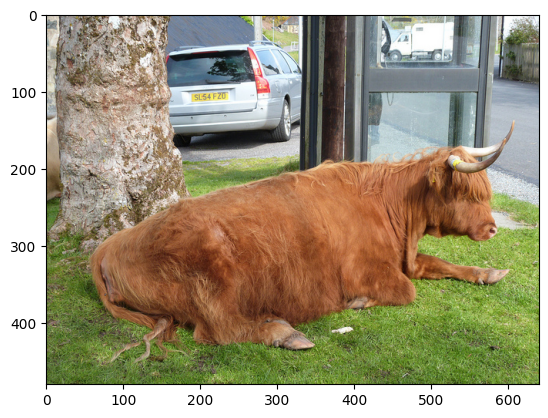

Enter a sentence to continue:
Sample 1 ------------------------------------
breaking at eos
###User: What type of animal is in the image?
###Bot: A large cow is standing in the image.
---------------
Sample 2 ------------------------------------
breaking at eos
###User: What type of animal is in the image?
###Bot: A pet is placed on the side of a city in the image.
---------------
Sample 3 ------------------------------------
breaking at eos
###User: What type of animal is in the image?
###Bot: An image of animal is featured in the image.
---------------
Enter a sentence to continue:
Sample 1 ------------------------------------
breaking at eos
###User: What type of animal is in the image?
###Bot: A cow is in the image.
---------------
Sample 2 ------------------------------------
breaking at eos
###User: What type of animal is in the image?
###Bot: A brown cow is in the image.
---------------
Sample 3 ------------------------------------
breaking at eos
###User: What type of animal is

In [4]:
def get_batch(device):
    i = random.randint(0, len(encoded)-1)
    tkns = torch.tensor(encoded[i], device=device).unsqueeze(0)
    return tkns, encoded_imgs[img_idxs[i]].to(device).unsqueeze(0), img_idxs[i]
    

if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)


# tokenizer
encode, decode = get_tokenizer('llama')

@torch.no_grad()
def generate(idx, max_new_tokens, temperature=1.0, top_k=None, break_at_eos=False, eos_token_id=None, img_enc=None):

    for _ in range(max_new_tokens):
        # if the sequence context is growing too long we must crop it at block_size
        idx_cond = idx if idx.size(1) <= 2048 else idx[:, -2048:]
        # forward the model to get the logits for the index in the sequence
        logits = model(idx_cond, img_enc=img_enc)
        # pluck the logits at the final step and scale by desired temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop the logits to only the top k options
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float('Inf')
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1)
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)
        
        if break_at_eos and idx_next.item() == eos_token_id:
            print("breaking at eos")
            break

    
    return idx

def sample(start):
    start_ids = encode(start)
    tkns = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

    # run generation
    with torch.no_grad():
        with ctx:
            for k in range(num_samples):
                # with time_gpu('Time to generate'):
                    print("Sample", k+1, "------------------------------------")
                    y = generate(tkns, max_new_tokens, temperature=temperature, top_k=top_k,
                                       break_at_eos=break_at_eos, eos_token_id=eos_token_id, 
                                       img_enc = img_enc) 
                                       
                    print(decode(y[0].tolist()))
                    print('---------------')
                  
tkns, img_enc, img_name = get_batch(device)  

print(img_name, decode(tkns[0].tolist()))
start = decode(tkns[0].tolist())
start = start[start.find("###Bot:")+7:-5] 

for i in trange(len(dataset['train'])):
    dt = dataset['train'][i]
    if start in dt['conversations'][1]['value']:
        break
                      
plt.imshow(Image.open('../cptData/llava/train2014/'+ "COCO_train2014_" + dt['image']))

plt.show()
if sampling == "discrete":
    # encode the beginning of the prompt
    if start.startswith('FILE:'):
        with open(start[5:], 'r', encoding='utf-8') as f:
            start = f.read()
    sample(start)


elif sampling == "continuous":
    while True:
        ## take input
        print("Enter a sentence to continue:")
        start = str(input())
        sample(start)
        
elif sampling == "format":
    while True:
        ## take input
        print("Enter a sentence to continue:")
        start = str(input())
        start = "###User: " + start + "\n###Bot: "
        sample(start)

In [18]:
start = decode(tkns[0].tolist())

In [22]:
start[start.find("###Bot:")+7:-5] 

'This image portrays a cozy living room with holiday cheer. A beautifully lit Christmas tree stands in the corner of the room, adding a festive touch. The room features a comfortable couch placed against the wall and a coffee table in the center. There is an entertainment center with a television to one side of the room, adorned with a few remotes and a cell phone nearby. \n\nBeside the couch, there is a chair, enhancing the seating arrangement in the space. In the room, numerous books are scattered throughout, perhaps indicating a reading-friendly atmosphere. Additionally, there are two teddy bears present, one sitting near the couch while the other is placed closer to the tree, contributing to the warm and welcoming ambi'

In [17]:
dt['conversations'][1]['value']

'The illuminated clocks on poles in the plaza serve both a practical and aesthetic purpose. Practically, they help people in the area track time, especially during night-time when regular clocks may be hard to read due to the lack of natural light. Aesthetically, the clocks enhance the ambiance and attractiveness of the city street, creating a unique and appealing atmosphere. One possible difficulty people might face in this area is that, despite the presence of several clocks, they may still have trouble finding or quickly glancing at the right clock, especially when they are in a rush or amidst a crowd. Additionally, the presence of numerous people in the plaza could potentially obstruct the view of the clocks, making them less visible or accessible during certain times or events.'

In [ ]:
for i in trange(len(dataset['train'])):
    dt = dataset['train'][i]
    if start[10:-10] in dt['conversations'][0]['value']:
        print(dt['image'])